In [1]:
from urllib.request import urlopen
import timm
import torch
import zipfile,os
from PIL import Image
from pathlib import Path
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader,Dataset
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim

In [2]:
pip install roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.7/88.7 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 34.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 51.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 85.7 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.11.0.86
    Uninstalling opencv-python-headless-4.11.0.86:
      Successfully uninstalled opencv-python-headless-4.11.0.86
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.8.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30

In [3]:
pip install scikit-learn==1.3.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 76.1 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
imbalanced-learn 0.13.0 requires scikit-learn<2,>=1.3.2, but you have scikit-learn 1.3.1 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install matplotlib==3.8.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 82.2 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.2
    Uninstalling matplotlib-3.7.2:
      Successfully uninstalled matplotlib-3.7.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.8.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
bigframes 2.8.0 requires google-cloud-bigquery[bqstorage,pandas]>=3.31.0, but you have google-cloud-bigquery 3.25.0 which is incompatible.
bigframes 2.8.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [5]:
from roboflow import Roboflow
rf = Roboflow(api_key="B5AgQrixtU1h66djOZMm")
project = rf.workspace("digihack").project("lung-disease-pbtdg")
version = project.version(2)
dataset = version.download("folder") 

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Lung-disease-2 in folder:: 100%|██████████| 8083/8083 [00:01<00:00, 6477.12it/s]


In [6]:
from roboflow import Roboflow
rf = Roboflow(api_key="Q1flzyg1J8Z2OMweLXf3")
project = rf.workspace("weapon-mpr3p").project("lung-disease-rybev")
version = project.version(1)
dataset2 = version.download("folder")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Lung-Disease-1 in folder:: 100%|██████████| 2029/2029 [00:00<00:00, 6520.99it/s]


In [7]:
train_dir = dataset.location + "/train"
test_dir = dataset2.location + "/train"
val_dir = dataset.location + "/valid"

In [8]:
model_name = 'swin_base_patch4_window7_224'

In [9]:
model = timm.create_model(
    model_name,
    pretrained=True,
    num_classes=5,
)
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

model = model.train()

# Get model specific transforms (normalization, resize)
data_config = timm.data.resolve_model_data_config(model)
print(f"Model expects input size: {data_config['input_size']}")
print(f"Model normalization: mean={data_config['mean']}, std={data_config['std']}")

# Create training and validation transforms
train_transform = timm.data.create_transform(**data_config, is_training=True)
val_transform = timm.data.create_transform(**data_config, is_training=False)

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

Model expects input size: (3, 224, 224)
Model normalization: mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)


In [10]:
class CustomDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.images = []
        self.labels = []
        
        # Get class names and sort them for consistency
        self.class_names = sorted(os.listdir(data_dir))
        print(f"Found classes: {self.class_names}")

        for label, class_name in enumerate(self.class_names):
            class_dir = os.path.join(data_dir, class_name)
            if os.path.isdir(class_dir):  # Only process directories
                class_images = [f for f in os.listdir(class_dir) 
                              if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]
                print(f"Class '{class_name}': {len(class_images)} images")
                
                for img_name in class_images:
                    img_path = os.path.join(class_dir, img_name)
                    self.images.append(img_path)
                    self.labels.append(label)
        
        print(f"Total images loaded: {len(self.images)}")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        try:
            image = Image.open(img_path).convert('RGB')
            label = self.labels[idx]

            if self.transform:
                image = self.transform(image)

            return image, label
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            # Return a black image if loading fails
            if self.transform:
                black_image = self.transform(Image.new('RGB', (224, 224), (0, 0, 0)))
            else:
                black_image = Image.new('RGB', (224, 224), (0, 0, 0))
            return black_image, self.labels[idx]


Found classes: ['Bacterial Pneumonia', 'Corona Virus Disease', 'Normal', 'Tuberculosis', 'Viral Pneumonia']
Class 'Bacterial Pneumonia': 1205 images
Class 'Corona Virus Disease': 1218 images
Class 'Normal': 1207 images
Class 'Tuberculosis': 1220 images
Class 'Viral Pneumonia': 1204 images
Total images loaded: 6054
Found classes: ['Bacterial Pneumonia', 'Corona Virus Disease', 'Normal', 'Tuberculosis', 'Viral Pneumonia']
Class 'Bacterial Pneumonia': 401 images
Class 'Corona Virus Disease': 405 images
Class 'Normal': 402 images
Class 'Tuberculosis': 406 images
Class 'Viral Pneumonia': 401 images
Total images loaded: 2015
=== Data Loading Test ===
Training batches: 378
Validation batches: 32
✅ Training batch shape: torch.Size([16, 3, 224, 224])
✅ Training labels shape: torch.Size([16])
✅ Input range: [-2.118, 2.640]
✅ Label range: [0, 4]
✅ Unique labels in batch: [0, 1, 2, 3, 4]


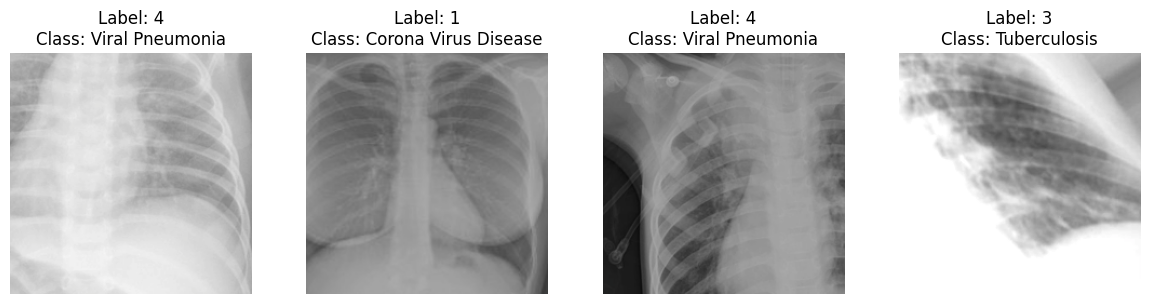


=== Data Loaders Ready ===
✅ Your dataset has 5 lung disease classes!
✅ Model updated to 5 classes - now everything should work!


In [11]:
# Quick data diagnostic
import matplotlib.pyplot as plt
import numpy as np

# Create datasets with appropriate transforms
train_dataset = CustomDataset(data_dir=train_dir, transform=train_transform)
val_dataset = CustomDataset(data_dir=val_dir, transform=val_transform)

# Create data loaders with NO workers for Kaggle compatibility
train_loader = DataLoader(
    train_dataset, 
    batch_size=16,
    shuffle=True, 
    num_workers=0,  # Set to 0 for Kaggle/Colab compatibility
    pin_memory=False,  # Disable pin_memory for stability
    drop_last=True
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=64,
    shuffle=False, 
    num_workers=0,  # Set to 0 for Kaggle/Colab compatibility
    pin_memory=False  # Disable pin_memory for stability
)

print("=== Data Loading Test ===")
print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")

# Test data loading and show sample
try:
    for data in train_loader:
        inputs, targets = data
        print(f"✅ Training batch shape: {inputs.shape}")
        print(f"✅ Training labels shape: {targets.shape}")
        print(f"✅ Input range: [{inputs.min().item():.3f}, {inputs.max().item():.3f}]")
        print(f"✅ Label range: [{targets.min().item()}, {targets.max().item()}]")
        print(f"✅ Unique labels in batch: {torch.unique(targets).tolist()}")
        
        # Show a few sample images
        fig, axes = plt.subplots(1, 4, figsize=(12, 3))
        for i in range(min(4, inputs.shape[0])):
            img = inputs[i]
            # Denormalize for display
            mean = torch.tensor(data_config['mean']).view(3, 1, 1)
            std = torch.tensor(data_config['std']).view(3, 1, 1)
            img = img * std + mean
            img = torch.clamp(img, 0, 1)
            
            axes[i].imshow(img.permute(1, 2, 0))
            axes[i].set_title(f"Label: {targets[i].item()}\nClass: {train_dataset.class_names[targets[i].item()]}")
            axes[i].axis('off')
        plt.tight_layout()
        plt.show()
        break
        
except Exception as e:
    print(f"❌ Error in data loading: {e}")
    print("This might be the source of your training issues!")

print("\n=== Data Loaders Ready ===")
print("✅ Your dataset has 5 lung disease classes!")
print("✅ Model updated to 5 classes - now everything should work!")

=== Dataset Information ===
Training samples: 6054
Validation samples: 2015
Training classes: ['Bacterial Pneumonia', 'Corona Virus Disease', 'Normal', 'Tuberculosis', 'Viral Pneumonia']
Validation classes: ['Bacterial Pneumonia', 'Corona Virus Disease', 'Normal', 'Tuberculosis', 'Viral Pneumonia']
Training class distribution: {'Bacterial Pneumonia': 1205, 'Corona Virus Disease': 1218, 'Normal': 1207, 'Tuberculosis': 1220, 'Viral Pneumonia': 1204}
Validation class distribution: {'Bacterial Pneumonia': 401, 'Corona Virus Disease': 405, 'Normal': 402, 'Tuberculosis': 406, 'Viral Pneumonia': 401}
Using device: cuda


The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.


Class weights: tensor([1.0048, 0.9941, 1.0031, 0.9925, 1.0056], device='cuda:0')

=== Starting Training ===


Epoch [1/100] Training: 100%|██████████| 378/378 [03:25<00:00,  1.84it/s, loss=0.4593, acc=71.1%]


Epoch [1/100] Training:
  Loss: 0.6987, Accuracy: 71.06%, F1: 0.7089


Epoch [1/100] Validation: 100%|██████████| 32/32 [00:33<00:00,  1.04s/it, loss=0.6209, acc=85.7%]


Epoch [1/100] Validation:
  Loss: 0.3881, Accuracy: 85.66%, F1: 0.8571
  ✅ Best model saved! Val Loss: 0.3881
  Learning Rate: 1.00e-04
------------------------------------------------------------


Epoch [2/100] Training: 100%|██████████| 378/378 [03:31<00:00,  1.79it/s, loss=0.2257, acc=80.9%]


Epoch [2/100] Training:
  Loss: 0.4745, Accuracy: 80.89%, F1: 0.8078


Epoch [2/100] Validation: 100%|██████████| 32/32 [00:32<00:00,  1.00s/it, loss=0.5108, acc=82.4%]


Epoch [2/100] Validation:
  Loss: 0.4122, Accuracy: 82.38%, F1: 0.8220
  Learning Rate: 1.00e-04
------------------------------------------------------------


Epoch [3/100] Training: 100%|██████████| 378/378 [03:30<00:00,  1.80it/s, loss=0.4919, acc=82.4%]


Epoch [3/100] Training:
  Loss: 0.4424, Accuracy: 82.42%, F1: 0.8231


Epoch [3/100] Validation: 100%|██████████| 32/32 [00:32<00:00,  1.03s/it, loss=0.8308, acc=86.8%]


Epoch [3/100] Validation:
  Loss: 0.3711, Accuracy: 86.80%, F1: 0.8667
  ✅ Best model saved! Val Loss: 0.3711
  Learning Rate: 1.00e-04
------------------------------------------------------------


Epoch [4/100] Training: 100%|██████████| 378/378 [03:31<00:00,  1.79it/s, loss=0.4353, acc=84.8%]


Epoch [4/100] Training:
  Loss: 0.3891, Accuracy: 84.84%, F1: 0.8475


Epoch [4/100] Validation: 100%|██████████| 32/32 [00:32<00:00,  1.03s/it, loss=1.0009, acc=87.0%]


Epoch [4/100] Validation:
  Loss: 0.3846, Accuracy: 87.05%, F1: 0.8658
  Learning Rate: 1.00e-04
------------------------------------------------------------


Epoch [5/100] Training: 100%|██████████| 378/378 [03:31<00:00,  1.78it/s, loss=0.6478, acc=83.5%]


Epoch [5/100] Training:
  Loss: 0.4073, Accuracy: 83.55%, F1: 0.8345


Epoch [5/100] Validation: 100%|██████████| 32/32 [00:33<00:00,  1.04s/it, loss=0.7269, acc=85.0%]


Epoch [5/100] Validation:
  Loss: 0.4030, Accuracy: 85.01%, F1: 0.8479
  Learning Rate: 1.00e-04
------------------------------------------------------------


Epoch [6/100] Training: 100%|██████████| 378/378 [03:29<00:00,  1.81it/s, loss=0.4637, acc=85.6%]


Epoch [6/100] Training:
  Loss: 0.3709, Accuracy: 85.65%, F1: 0.8557


Epoch [6/100] Validation: 100%|██████████| 32/32 [00:31<00:00,  1.01it/s, loss=0.8876, acc=87.5%]


Epoch [6/100] Validation:
  Loss: 0.3481, Accuracy: 87.54%, F1: 0.8743
  ✅ Best model saved! Val Loss: 0.3481
  Learning Rate: 1.00e-04
------------------------------------------------------------


Epoch [7/100] Training: 100%|██████████| 378/378 [03:29<00:00,  1.80it/s, loss=0.4930, acc=85.7%]


Epoch [7/100] Training:
  Loss: 0.3540, Accuracy: 85.73%, F1: 0.8564


Epoch [7/100] Validation: 100%|██████████| 32/32 [00:32<00:00,  1.02s/it, loss=0.3757, acc=87.8%]


Epoch [7/100] Validation:
  Loss: 0.2966, Accuracy: 87.79%, F1: 0.8785
  ✅ Best model saved! Val Loss: 0.2966
  Learning Rate: 1.00e-04
------------------------------------------------------------


Epoch [8/100] Training: 100%|██████████| 378/378 [03:30<00:00,  1.80it/s, loss=0.5679, acc=85.6%]


Epoch [8/100] Training:
  Loss: 0.3585, Accuracy: 85.63%, F1: 0.8557


Epoch [8/100] Validation: 100%|██████████| 32/32 [00:32<00:00,  1.02s/it, loss=0.6631, acc=89.4%]


Epoch [8/100] Validation:
  Loss: 0.2756, Accuracy: 89.38%, F1: 0.8929
  ✅ Best model saved! Val Loss: 0.2756
  Learning Rate: 1.00e-04
------------------------------------------------------------


Epoch [9/100] Training: 100%|██████████| 378/378 [03:30<00:00,  1.79it/s, loss=0.2393, acc=86.4%]


Epoch [9/100] Training:
  Loss: 0.3537, Accuracy: 86.43%, F1: 0.8632


Epoch [9/100] Validation: 100%|██████████| 32/32 [00:32<00:00,  1.02s/it, loss=0.7274, acc=89.1%]


Epoch [9/100] Validation:
  Loss: 0.2770, Accuracy: 89.08%, F1: 0.8902
  Learning Rate: 1.00e-04
------------------------------------------------------------


Epoch [10/100] Training: 100%|██████████| 378/378 [03:29<00:00,  1.81it/s, loss=0.8723, acc=87.5%]


Epoch [10/100] Training:
  Loss: 0.3298, Accuracy: 87.52%, F1: 0.8748


Epoch [10/100] Validation: 100%|██████████| 32/32 [00:31<00:00,  1.00it/s, loss=1.9312, acc=79.2%]


Epoch [10/100] Validation:
  Loss: 0.6201, Accuracy: 79.21%, F1: 0.7831
  Learning Rate: 1.00e-04
------------------------------------------------------------


Epoch [11/100] Training: 100%|██████████| 378/378 [03:28<00:00,  1.81it/s, loss=0.5233, acc=88.4%]


Epoch [11/100] Training:
  Loss: 0.3184, Accuracy: 88.38%, F1: 0.8833


Epoch [11/100] Validation: 100%|██████████| 32/32 [00:31<00:00,  1.01it/s, loss=0.5260, acc=87.8%]


Epoch [11/100] Validation:
  Loss: 0.3093, Accuracy: 87.79%, F1: 0.8789
  Learning Rate: 1.00e-04
------------------------------------------------------------


Epoch [12/100] Training: 100%|██████████| 378/378 [03:25<00:00,  1.84it/s, loss=0.5090, acc=87.5%]


Epoch [12/100] Training:
  Loss: 0.3282, Accuracy: 87.53%, F1: 0.8748


Epoch [12/100] Validation: 100%|██████████| 32/32 [00:31<00:00,  1.03it/s, loss=1.2024, acc=89.5%]


Epoch [12/100] Validation:
  Loss: 0.3058, Accuracy: 89.53%, F1: 0.8912
  Learning Rate: 5.00e-05
------------------------------------------------------------


Epoch [13/100] Training: 100%|██████████| 378/378 [03:24<00:00,  1.85it/s, loss=0.4866, acc=90.2%]


Epoch [13/100] Training:
  Loss: 0.2560, Accuracy: 90.20%, F1: 0.9015


Epoch [13/100] Validation: 100%|██████████| 32/32 [00:31<00:00,  1.01it/s, loss=1.4976, acc=89.0%]


Epoch [13/100] Validation:
  Loss: 0.3522, Accuracy: 89.03%, F1: 0.8841
  Learning Rate: 5.00e-05
------------------------------------------------------------


Epoch [14/100] Training: 100%|██████████| 378/378 [03:26<00:00,  1.83it/s, loss=0.3873, acc=90.6%]


Epoch [14/100] Training:
  Loss: 0.2456, Accuracy: 90.58%, F1: 0.9055


Epoch [14/100] Validation: 100%|██████████| 32/32 [00:31<00:00,  1.01it/s, loss=0.7881, acc=90.8%]


Epoch [14/100] Validation:
  Loss: 0.2953, Accuracy: 90.82%, F1: 0.9071
  Learning Rate: 5.00e-05
------------------------------------------------------------


Epoch [15/100] Training: 100%|██████████| 378/378 [03:28<00:00,  1.82it/s, loss=0.0091, acc=90.9%]


Epoch [15/100] Training:
  Loss: 0.2413, Accuracy: 90.89%, F1: 0.9086


Epoch [15/100] Validation: 100%|██████████| 32/32 [00:31<00:00,  1.02it/s, loss=1.3048, acc=91.3%]


Epoch [15/100] Validation:
  Loss: 0.3059, Accuracy: 91.27%, F1: 0.9104
  Learning Rate: 5.00e-05
------------------------------------------------------------


Epoch [16/100] Training: 100%|██████████| 378/378 [03:26<00:00,  1.83it/s, loss=0.3788, acc=91.0%]


Epoch [16/100] Training:
  Loss: 0.2412, Accuracy: 91.01%, F1: 0.9098


Epoch [16/100] Validation: 100%|██████████| 32/32 [00:31<00:00,  1.02it/s, loss=0.8282, acc=90.9%]


Epoch [16/100] Validation:
  Loss: 0.2639, Accuracy: 90.87%, F1: 0.9087
  ✅ Best model saved! Val Loss: 0.2639
  Learning Rate: 5.00e-05
------------------------------------------------------------


Epoch [17/100] Training: 100%|██████████| 378/378 [03:26<00:00,  1.83it/s, loss=0.1590, acc=91.0%]


Epoch [17/100] Training:
  Loss: 0.2340, Accuracy: 91.01%, F1: 0.9100


Epoch [17/100] Validation: 100%|██████████| 32/32 [00:31<00:00,  1.02it/s, loss=1.3427, acc=91.3%]


Epoch [17/100] Validation:
  Loss: 0.3251, Accuracy: 91.32%, F1: 0.9115
  Learning Rate: 5.00e-05
------------------------------------------------------------


Epoch [18/100] Training: 100%|██████████| 378/378 [03:25<00:00,  1.84it/s, loss=0.4678, acc=91.8%]


Epoch [18/100] Training:
  Loss: 0.2351, Accuracy: 91.85%, F1: 0.9183


Epoch [18/100] Validation: 100%|██████████| 32/32 [00:30<00:00,  1.03it/s, loss=1.0663, acc=90.6%]


Epoch [18/100] Validation:
  Loss: 0.2865, Accuracy: 90.62%, F1: 0.9029
  Learning Rate: 5.00e-05
------------------------------------------------------------


Epoch [19/100] Training: 100%|██████████| 378/378 [03:25<00:00,  1.84it/s, loss=0.2917, acc=91.8%]


Epoch [19/100] Training:
  Loss: 0.2231, Accuracy: 91.80%, F1: 0.9178


Epoch [19/100] Validation: 100%|██████████| 32/32 [00:31<00:00,  1.03it/s, loss=0.9457, acc=91.3%]


Epoch [19/100] Validation:
  Loss: 0.2708, Accuracy: 91.27%, F1: 0.9119
  Learning Rate: 5.00e-05
------------------------------------------------------------


Epoch [20/100] Training: 100%|██████████| 378/378 [03:24<00:00,  1.85it/s, loss=0.1408, acc=91.7%]


Epoch [20/100] Training:
  Loss: 0.2210, Accuracy: 91.68%, F1: 0.9167


Epoch [20/100] Validation: 100%|██████████| 32/32 [00:30<00:00,  1.03it/s, loss=0.8874, acc=88.8%]


Epoch [20/100] Validation:
  Loss: 0.3882, Accuracy: 88.78%, F1: 0.8859
  Learning Rate: 2.50e-05
------------------------------------------------------------


Epoch [21/100] Training: 100%|██████████| 378/378 [03:24<00:00,  1.85it/s, loss=0.2426, acc=93.1%]


Epoch [21/100] Training:
  Loss: 0.1889, Accuracy: 93.12%, F1: 0.9310


Epoch [21/100] Validation: 100%|██████████| 32/32 [00:31<00:00,  1.03it/s, loss=1.1086, acc=91.4%]


Epoch [21/100] Validation:
  Loss: 0.2847, Accuracy: 91.36%, F1: 0.9123
  Learning Rate: 2.50e-05
------------------------------------------------------------


Epoch [22/100] Training: 100%|██████████| 378/378 [03:24<00:00,  1.85it/s, loss=0.0636, acc=93.7%]


Epoch [22/100] Training:
  Loss: 0.1739, Accuracy: 93.65%, F1: 0.9364


Epoch [22/100] Validation: 100%|██████████| 32/32 [00:30<00:00,  1.04it/s, loss=0.9554, acc=91.3%]


Epoch [22/100] Validation:
  Loss: 0.3283, Accuracy: 91.32%, F1: 0.9122
  Learning Rate: 2.50e-05
------------------------------------------------------------


Epoch [23/100] Training: 100%|██████████| 378/378 [03:24<00:00,  1.85it/s, loss=0.3133, acc=93.6%]


Epoch [23/100] Training:
  Loss: 0.1826, Accuracy: 93.58%, F1: 0.9359


Epoch [23/100] Validation: 100%|██████████| 32/32 [00:31<00:00,  1.03it/s, loss=0.9484, acc=91.4%]


Epoch [23/100] Validation:
  Loss: 0.3066, Accuracy: 91.36%, F1: 0.9124
  Learning Rate: 2.50e-05
------------------------------------------------------------


Epoch [24/100] Training: 100%|██████████| 378/378 [03:25<00:00,  1.84it/s, loss=0.1303, acc=93.9%]


Epoch [24/100] Training:
  Loss: 0.1685, Accuracy: 93.87%, F1: 0.9386


Epoch [24/100] Validation: 100%|██████████| 32/32 [00:30<00:00,  1.04it/s, loss=1.1279, acc=91.8%]


Epoch [24/100] Validation:
  Loss: 0.3001, Accuracy: 91.76%, F1: 0.9174
  Learning Rate: 1.25e-05
------------------------------------------------------------


Epoch [25/100] Training: 100%|██████████| 378/378 [03:25<00:00,  1.84it/s, loss=0.3115, acc=94.3%]


Epoch [25/100] Training:
  Loss: 0.1591, Accuracy: 94.26%, F1: 0.9426


Epoch [25/100] Validation: 100%|██████████| 32/32 [00:30<00:00,  1.04it/s, loss=1.1401, acc=91.5%]


Epoch [25/100] Validation:
  Loss: 0.3060, Accuracy: 91.51%, F1: 0.9143
  Learning Rate: 1.25e-05
------------------------------------------------------------


Epoch [26/100] Training: 100%|██████████| 378/378 [03:25<00:00,  1.84it/s, loss=0.6059, acc=94.8%]


Epoch [26/100] Training:
  Loss: 0.1477, Accuracy: 94.79%, F1: 0.9479


Epoch [26/100] Validation: 100%|██████████| 32/32 [00:31<00:00,  1.01it/s, loss=1.2601, acc=91.8%]


Epoch [26/100] Validation:
  Loss: 0.3282, Accuracy: 91.76%, F1: 0.9160
  Learning Rate: 1.25e-05
------------------------------------------------------------


Epoch [27/100] Training: 100%|██████████| 378/378 [03:23<00:00,  1.85it/s, loss=0.1160, acc=94.8%]


Epoch [27/100] Training:
  Loss: 0.1445, Accuracy: 94.78%, F1: 0.9476


Epoch [27/100] Validation: 100%|██████████| 32/32 [00:31<00:00,  1.01it/s, loss=1.2143, acc=92.1%]


Epoch [27/100] Validation:
  Loss: 0.3139, Accuracy: 92.11%, F1: 0.9201
  Learning Rate: 1.25e-05
------------------------------------------------------------


Epoch [28/100] Training: 100%|██████████| 378/378 [03:25<00:00,  1.84it/s, loss=0.1436, acc=94.7%]


Epoch [28/100] Training:
  Loss: 0.1421, Accuracy: 94.68%, F1: 0.9467


Epoch [28/100] Validation: 100%|██████████| 32/32 [00:31<00:00,  1.02it/s, loss=0.8853, acc=92.1%]


Epoch [28/100] Validation:
  Loss: 0.3299, Accuracy: 92.11%, F1: 0.9204
  Learning Rate: 6.25e-06
------------------------------------------------------------


Epoch [29/100] Training: 100%|██████████| 378/378 [03:23<00:00,  1.86it/s, loss=0.1734, acc=95.5%]


Epoch [29/100] Training:
  Loss: 0.1292, Accuracy: 95.50%, F1: 0.9550


Epoch [29/100] Validation: 100%|██████████| 32/32 [00:30<00:00,  1.06it/s, loss=0.9051, acc=92.3%]


Epoch [29/100] Validation:
  Loss: 0.3107, Accuracy: 92.31%, F1: 0.9225
  Learning Rate: 6.25e-06
------------------------------------------------------------


Epoch [30/100] Training: 100%|██████████| 378/378 [03:22<00:00,  1.86it/s, loss=0.1832, acc=95.4%]


Epoch [30/100] Training:
  Loss: 0.1341, Accuracy: 95.39%, F1: 0.9538


Epoch [30/100] Validation: 100%|██████████| 32/32 [00:29<00:00,  1.07it/s, loss=0.9448, acc=91.8%]


Epoch [30/100] Validation:
  Loss: 0.3373, Accuracy: 91.81%, F1: 0.9173
  Learning Rate: 6.25e-06
------------------------------------------------------------


Epoch [31/100] Training: 100%|██████████| 378/378 [03:23<00:00,  1.86it/s, loss=0.2917, acc=95.4%]


Epoch [31/100] Training:
  Loss: 0.1268, Accuracy: 95.37%, F1: 0.9537


Epoch [31/100] Validation: 100%|██████████| 32/32 [00:30<00:00,  1.04it/s, loss=1.1382, acc=92.0%]


Epoch [31/100] Validation:
  Loss: 0.3489, Accuracy: 92.01%, F1: 0.9191
  Learning Rate: 6.25e-06
------------------------------------------------------------


Epoch [32/100] Training: 100%|██████████| 378/378 [03:24<00:00,  1.85it/s, loss=0.0655, acc=95.0%]


Epoch [32/100] Training:
  Loss: 0.1440, Accuracy: 94.97%, F1: 0.9497


Epoch [32/100] Validation: 100%|██████████| 32/32 [00:30<00:00,  1.03it/s, loss=0.9976, acc=91.9%]


Epoch [32/100] Validation:
  Loss: 0.3373, Accuracy: 91.91%, F1: 0.9183
  Learning Rate: 3.13e-06
------------------------------------------------------------


Epoch [33/100] Training: 100%|██████████| 378/378 [03:24<00:00,  1.85it/s, loss=0.0167, acc=95.8%]


Epoch [33/100] Training:
  Loss: 0.1241, Accuracy: 95.82%, F1: 0.9581


Epoch [33/100] Validation: 100%|██████████| 32/32 [00:31<00:00,  1.02it/s, loss=1.1034, acc=92.1%]


Epoch [33/100] Validation:
  Loss: 0.3417, Accuracy: 92.11%, F1: 0.9202
  Learning Rate: 3.13e-06
------------------------------------------------------------


Epoch [34/100] Training: 100%|██████████| 378/378 [03:25<00:00,  1.84it/s, loss=0.0153, acc=95.8%]


Epoch [34/100] Training:
  Loss: 0.1264, Accuracy: 95.85%, F1: 0.9584


Epoch [34/100] Validation: 100%|██████████| 32/32 [00:30<00:00,  1.04it/s, loss=1.0796, acc=92.2%]


Epoch [34/100] Validation:
  Loss: 0.3394, Accuracy: 92.21%, F1: 0.9213
  Learning Rate: 3.13e-06
------------------------------------------------------------


Epoch [35/100] Training: 100%|██████████| 378/378 [03:24<00:00,  1.85it/s, loss=0.2604, acc=95.9%]


Epoch [35/100] Training:
  Loss: 0.1183, Accuracy: 95.88%, F1: 0.9588


Epoch [35/100] Validation: 100%|██████████| 32/32 [00:30<00:00,  1.05it/s, loss=1.1392, acc=92.3%]


Epoch [35/100] Validation:
  Loss: 0.3416, Accuracy: 92.26%, F1: 0.9218
  Learning Rate: 3.13e-06
------------------------------------------------------------


Epoch [36/100] Training: 100%|██████████| 378/378 [03:24<00:00,  1.85it/s, loss=0.0068, acc=95.7%]


Epoch [36/100] Training:
  Loss: 0.1274, Accuracy: 95.65%, F1: 0.9564


Epoch [36/100] Validation: 100%|██████████| 32/32 [00:30<00:00,  1.04it/s, loss=1.1125, acc=92.5%]


Epoch [36/100] Validation:
  Loss: 0.3386, Accuracy: 92.51%, F1: 0.9245
  Learning Rate: 1.56e-06
------------------------------------------------------------


Epoch [37/100] Training: 100%|██████████| 378/378 [03:25<00:00,  1.84it/s, loss=0.2283, acc=95.7%]


Epoch [37/100] Training:
  Loss: 0.1266, Accuracy: 95.73%, F1: 0.9573


Epoch [37/100] Validation: 100%|██████████| 32/32 [00:31<00:00,  1.01it/s, loss=1.0969, acc=92.3%]


Epoch [37/100] Validation:
  Loss: 0.3407, Accuracy: 92.31%, F1: 0.9224
  Learning Rate: 1.56e-06
------------------------------------------------------------


Epoch [38/100] Training: 100%|██████████| 378/378 [03:26<00:00,  1.83it/s, loss=0.0030, acc=95.9%]


Epoch [38/100] Training:
  Loss: 0.1189, Accuracy: 95.90%, F1: 0.9589


Epoch [38/100] Validation: 100%|██████████| 32/32 [00:31<00:00,  1.01it/s, loss=1.1230, acc=92.7%]


Epoch [38/100] Validation:
  Loss: 0.3443, Accuracy: 92.66%, F1: 0.9259
  Learning Rate: 1.56e-06
------------------------------------------------------------


Epoch [39/100] Training: 100%|██████████| 378/378 [03:27<00:00,  1.82it/s, loss=0.1238, acc=96.2%]


Epoch [39/100] Training:
  Loss: 0.1121, Accuracy: 96.18%, F1: 0.9617


Epoch [39/100] Validation: 100%|██████████| 32/32 [00:31<00:00,  1.00it/s, loss=1.2039, acc=92.6%]


Epoch [39/100] Validation:
  Loss: 0.3498, Accuracy: 92.56%, F1: 0.9249
  Learning Rate: 1.56e-06
------------------------------------------------------------


Epoch [40/100] Training: 100%|██████████| 378/378 [03:26<00:00,  1.83it/s, loss=0.0780, acc=95.8%]


Epoch [40/100] Training:
  Loss: 0.1187, Accuracy: 95.82%, F1: 0.9581


Epoch [40/100] Validation: 100%|██████████| 32/32 [00:31<00:00,  1.03it/s, loss=1.1109, acc=92.7%]


Epoch [40/100] Validation:
  Loss: 0.3472, Accuracy: 92.66%, F1: 0.9260
  Learning Rate: 7.81e-07
------------------------------------------------------------


Epoch [41/100] Training: 100%|██████████| 378/378 [03:26<00:00,  1.83it/s, loss=0.0674, acc=96.1%]


Epoch [41/100] Training:
  Loss: 0.1191, Accuracy: 96.06%, F1: 0.9606


Epoch [41/100] Validation: 100%|██████████| 32/32 [00:30<00:00,  1.04it/s, loss=1.1088, acc=92.6%]


Epoch [41/100] Validation:
  Loss: 0.3499, Accuracy: 92.61%, F1: 0.9255
  Learning Rate: 7.81e-07
------------------------------------------------------------


Epoch [42/100] Training: 100%|██████████| 378/378 [03:25<00:00,  1.84it/s, loss=0.2344, acc=96.2%]


Epoch [42/100] Training:
  Loss: 0.1157, Accuracy: 96.23%, F1: 0.9623


Epoch [42/100] Validation: 100%|██████████| 32/32 [00:31<00:00,  1.02it/s, loss=1.0912, acc=92.7%]


Epoch [42/100] Validation:
  Loss: 0.3488, Accuracy: 92.70%, F1: 0.9265
  Learning Rate: 7.81e-07
------------------------------------------------------------


Epoch [43/100] Training: 100%|██████████| 378/378 [03:25<00:00,  1.84it/s, loss=0.0323, acc=96.5%]


Epoch [43/100] Training:
  Loss: 0.1021, Accuracy: 96.46%, F1: 0.9645


Epoch [43/100] Validation: 100%|██████████| 32/32 [00:30<00:00,  1.03it/s, loss=1.2063, acc=92.8%]


Epoch [43/100] Validation:
  Loss: 0.3541, Accuracy: 92.75%, F1: 0.9268
  Learning Rate: 7.81e-07
------------------------------------------------------------


Epoch [44/100] Training: 100%|██████████| 378/378 [03:24<00:00,  1.85it/s, loss=0.0902, acc=96.1%]


Epoch [44/100] Training:
  Loss: 0.1196, Accuracy: 96.11%, F1: 0.9610


Epoch [44/100] Validation: 100%|██████████| 32/32 [00:31<00:00,  1.03it/s, loss=1.1758, acc=92.6%]


Epoch [44/100] Validation:
  Loss: 0.3528, Accuracy: 92.56%, F1: 0.9250
  Learning Rate: 3.91e-07
------------------------------------------------------------


Epoch [45/100] Training: 100%|██████████| 378/378 [03:23<00:00,  1.86it/s, loss=0.2907, acc=95.8%]


Epoch [45/100] Training:
  Loss: 0.1209, Accuracy: 95.78%, F1: 0.9577


Epoch [45/100] Validation: 100%|██████████| 32/32 [00:30<00:00,  1.06it/s, loss=1.1899, acc=92.5%]


Epoch [45/100] Validation:
  Loss: 0.3568, Accuracy: 92.46%, F1: 0.9239
  Learning Rate: 3.91e-07
------------------------------------------------------------


Epoch [46/100] Training: 100%|██████████| 378/378 [03:23<00:00,  1.86it/s, loss=0.1907, acc=96.1%]


Epoch [46/100] Training:
  Loss: 0.1237, Accuracy: 96.11%, F1: 0.9611


Epoch [46/100] Validation: 100%|██████████| 32/32 [00:31<00:00,  1.00it/s, loss=1.2300, acc=92.7%]


Epoch [46/100] Validation:
  Loss: 0.3562, Accuracy: 92.70%, F1: 0.9263
  Learning Rate: 3.91e-07
------------------------------------------------------------


Epoch [47/100] Training: 100%|██████████| 378/378 [03:25<00:00,  1.84it/s, loss=0.1450, acc=95.8%]


Epoch [47/100] Training:
  Loss: 0.1232, Accuracy: 95.80%, F1: 0.9579


Epoch [47/100] Validation: 100%|██████████| 32/32 [00:31<00:00,  1.02it/s, loss=1.2007, acc=92.7%]


Epoch [47/100] Validation:
  Loss: 0.3507, Accuracy: 92.70%, F1: 0.9263
  Learning Rate: 3.91e-07
------------------------------------------------------------


Epoch [48/100] Training: 100%|██████████| 378/378 [03:26<00:00,  1.83it/s, loss=0.0163, acc=96.3%]


Epoch [48/100] Training:
  Loss: 0.1100, Accuracy: 96.31%, F1: 0.9631


Epoch [48/100] Validation: 100%|██████████| 32/32 [00:31<00:00,  1.02it/s, loss=1.1686, acc=92.6%]


Epoch [48/100] Validation:
  Loss: 0.3540, Accuracy: 92.56%, F1: 0.9249
  Learning Rate: 1.95e-07
------------------------------------------------------------


Epoch [49/100] Training: 100%|██████████| 378/378 [03:27<00:00,  1.82it/s, loss=0.0032, acc=96.3%]


Epoch [49/100] Training:
  Loss: 0.1135, Accuracy: 96.26%, F1: 0.9627


Epoch [49/100] Validation: 100%|██████████| 32/32 [00:31<00:00,  1.02it/s, loss=1.1730, acc=92.6%]


Epoch [49/100] Validation:
  Loss: 0.3528, Accuracy: 92.56%, F1: 0.9249
  Learning Rate: 1.95e-07
------------------------------------------------------------


Epoch [50/100] Training: 100%|██████████| 378/378 [03:26<00:00,  1.83it/s, loss=0.0030, acc=96.3%]


Epoch [50/100] Training:
  Loss: 0.1117, Accuracy: 96.28%, F1: 0.9627


Epoch [50/100] Validation: 100%|██████████| 32/32 [00:31<00:00,  1.01it/s, loss=1.2074, acc=92.5%]


Epoch [50/100] Validation:
  Loss: 0.3536, Accuracy: 92.51%, F1: 0.9244
  Learning Rate: 1.95e-07
------------------------------------------------------------


Epoch [51/100] Training: 100%|██████████| 378/378 [03:27<00:00,  1.82it/s, loss=0.0068, acc=96.3%]


Epoch [51/100] Training:
  Loss: 0.1132, Accuracy: 96.33%, F1: 0.9632


Epoch [51/100] Validation: 100%|██████████| 32/32 [00:31<00:00,  1.00it/s, loss=1.1926, acc=92.6%]


Epoch [51/100] Validation:
  Loss: 0.3530, Accuracy: 92.61%, F1: 0.9254
  Learning Rate: 1.95e-07
------------------------------------------------------------


Epoch [52/100] Training: 100%|██████████| 378/378 [03:25<00:00,  1.84it/s, loss=0.3386, acc=96.3%]


Epoch [52/100] Training:
  Loss: 0.1124, Accuracy: 96.31%, F1: 0.9631


Epoch [52/100] Validation: 100%|██████████| 32/32 [00:31<00:00,  1.02it/s, loss=1.1815, acc=92.6%]


Epoch [52/100] Validation:
  Loss: 0.3529, Accuracy: 92.61%, F1: 0.9255
  Learning Rate: 9.77e-08
------------------------------------------------------------
Learning rate too small, stopping training.


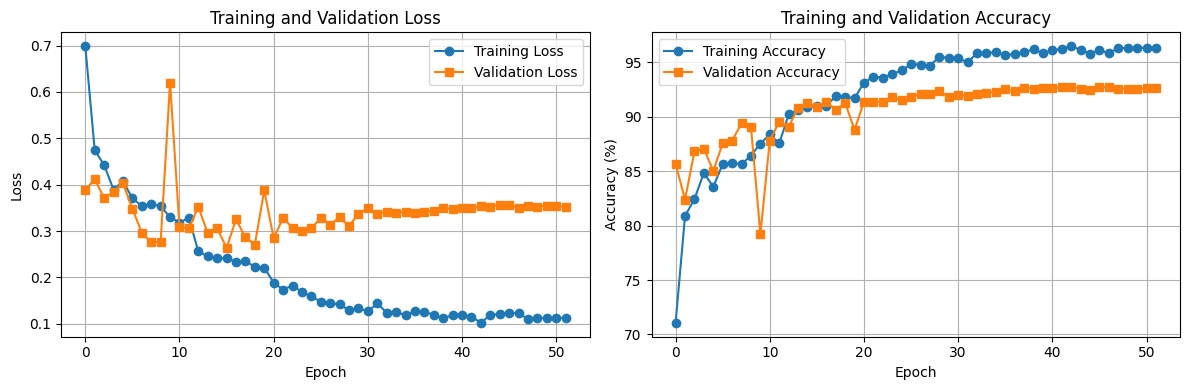


=== Training Complete ===
Best validation loss: 0.2639
Final training accuracy: 96.31%
Final validation accuracy: 92.61%


In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt

# Check data distribution first
print("=== Dataset Information ===")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Training classes: {train_dataset.class_names}")
print(f"Validation classes: {val_dataset.class_names}")

# Count class distribution
train_class_counts = {}
for label in train_dataset.labels:
    class_name = train_dataset.class_names[label]
    train_class_counts[class_name] = train_class_counts.get(class_name, 0) + 1
print(f"Training class distribution: {train_class_counts}")

val_class_counts = {}
for label in val_dataset.labels:
    class_name = val_dataset.class_names[label]
    val_class_counts[class_name] = val_class_counts.get(class_name, 0) + 1
print(f"Validation class distribution: {val_class_counts}")

# Setup device and model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Move model to device and ensure it's in training mode
model.to(device)
model.train()

# Define loss function with class weights for imbalanced data
total_train = len(train_dataset)
class_weights = []
for class_name in train_dataset.class_names:
    class_count = train_class_counts.get(class_name, 1)
    weight = total_train / (len(train_dataset.class_names) * class_count)
    class_weights.append(weight)

class_weights = torch.FloatTensor(class_weights).to(device)
print(f"Class weights: {class_weights}")

criterion = nn.CrossEntropyLoss(weight=class_weights)

# Optimizer with lower learning rate
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3, verbose=True
)

# Training parameters
num_epochs = 100
best_val_loss = float('inf')
save_path = "./best_model.pth"

# Lists to store training history
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

print("\n=== Starting Training ===")

for epoch in range(num_epochs):
    # ====================================================================
    #                            TRAINING LOOP
    # ====================================================================
    model.train()
    epoch_loss = 0
    correct_predictions = 0
    total_samples = 0
    all_targets = []
    all_preds = []
    
    progress_bar = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] Training")
    
    for batch_idx, (inputs, targets) in enumerate(progress_bar):
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # Backward pass
        loss.backward()
        
        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        # Update weights
        optimizer.step()
        
        # Statistics
        _, predicted = torch.max(outputs.data, 1)
        total_samples += targets.size(0)
        correct_predictions += (predicted == targets).sum().item()
        
        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())
        
        epoch_loss += loss.item()
        
        # Update progress bar
        current_acc = 100.0 * correct_predictions / total_samples
        progress_bar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{current_acc:.1f}%'
        })
    
    # Calculate training metrics
    avg_train_loss = epoch_loss / len(train_loader)
    train_accuracy = 100.0 * correct_predictions / total_samples
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_targets, all_preds, average='weighted', zero_division=0
    )
    
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)
    
    print(f"Epoch [{epoch+1}/{num_epochs}] Training:")
    print(f"  Loss: {avg_train_loss:.4f}, Accuracy: {train_accuracy:.2f}%, F1: {f1:.4f}")
    
    # ====================================================================
    #                           VALIDATION LOOP
    # ====================================================================
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    all_val_targets = []
    all_val_preds = []
    
    with torch.no_grad():
        val_progress_bar = tqdm(val_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] Validation")
        for inputs, targets in val_progress_bar:
            inputs, targets = inputs.to(device), targets.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += targets.size(0)
            val_correct += (predicted == targets).sum().item()
            
            all_val_preds.extend(predicted.cpu().numpy())
            all_val_targets.extend(targets.cpu().numpy())
            
            # Update progress bar
            current_val_acc = 100.0 * val_correct / val_total
            val_progress_bar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{current_val_acc:.1f}%'
            })
    
    # Calculate validation metrics
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = 100.0 * val_correct / val_total
    val_precision, val_recall, val_f1, _ = precision_recall_fscore_support(
        all_val_targets, all_val_preds, average='weighted', zero_division=0
    )
    
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)
    
    print(f"Epoch [{epoch+1}/{num_epochs}] Validation:")
    print(f"  Loss: {avg_val_loss:.4f}, Accuracy: {val_accuracy:.2f}%, F1: {val_f1:.4f}")
    
    # Save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), save_path)
        print(f"  ✅ Best model saved! Val Loss: {best_val_loss:.4f}")
    
    # Learning rate scheduling
    scheduler.step(avg_val_loss)
    current_lr = optimizer.param_groups[0]['lr']
    print(f"  Learning Rate: {current_lr:.2e}")
    print("-" * 60)
    
    # Early stopping if learning rate gets too small
    if current_lr < 1e-7:
        print("Learning rate too small, stopping training.")
        break

# Save final model
torch.save(model.state_dict(), "./last_model.pth")

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='s')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy', marker='o')
plt.plot(val_accuracies, label='Validation Accuracy', marker='s')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('training_history.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n=== Training Complete ===")
print(f"Best validation loss: {best_val_loss:.4f}")
print(f"Final training accuracy: {train_accuracies[-1]:.2f}%")
print(f"Final validation accuracy: {val_accuracies[-1]:.2f}%")

In [13]:
import csv
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import timm

# ==============================
# CUSTOM DATASET WITH PATHS
# ==============================
class ImageFolderWithPaths(ImageFolder):
    """Custom dataset that includes image file paths."""
    def __getitem__(self, index):
        # Normal ImageFolder return (img, label)
        original_tuple = super().__getitem__(index)
        path = self.samples[index][0]  # file path
        return original_tuple + (path,)  # (img, label, path)

# ==============================
# DATASET & LOADER
# ==============================
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

test_dataset = ImageFolderWithPaths(root=test_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# ==============================
# DEVICE
# ==============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ==============================
# MODEL
# ==============================
model = timm.create_model(
    model_name,
    pretrained=True,
    num_classes=5,
)

if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

model.to(device)

# ==============================
# LOAD BEST MODEL
# ==============================
state_dict = torch.load("./best_model.pth", map_location=device)
model.load_state_dict(state_dict)
#if isinstance(model, nn.DataParallel):
#    model.module.load_state_dict(state_dict)
#else:
#    model.load_state_dict(state_dict)

model.eval()
print("✅ Loaded best_model.pth successfully.")

# ==============================
# PREDICTION LOOP
# ==============================
results = []

with torch.no_grad():
    for inputs, _, paths in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, dim=1)

        for path, pred in zip(paths, preds.cpu().numpy()):
            filename = os.path.basename(path)

            # ✅ Clean up Roboflow suffix like ".rf.xxxxx"
            if ".rf." in filename:
                filename = filename.split(".rf.")[0]

            results.append([filename, pred])

# ==============================
# SAVE CSV
# ==============================
csv_file = "test_predictions.csv"
with open(csv_file, mode="w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["Id", "Predicted"])  # header
    writer.writerows(results)

print(f"✅ Predictions saved to {csv_file}")


✅ Loaded best_model.pth successfully.
✅ Predictions saved to test_predictions.csv


In [14]:
import csv
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import timm

# ==============================
# CUSTOM DATASET WITH PATHS
# ==============================
class ImageFolderWithPaths(ImageFolder):
    """Custom dataset that includes image file paths."""
    def __getitem__(self, index):
        # Normal ImageFolder return (img, label)
        original_tuple = super().__getitem__(index)
        path = self.samples[index][0]  # file path
        return original_tuple + (path,)  # (img, label, path)

# ==============================
# DATASET & LOADER
# ==============================
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

test_dataset = ImageFolderWithPaths(root=test_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# ==============================
# DEVICE
# ==============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ==============================
# MODEL
# ==============================
model = timm.create_model(
    model_name,
    pretrained=True,
    num_classes=5,
)

if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

model.to(device)

# ==============================
# LOAD BEST MODEL
# ==============================
state_dict = torch.load("./best_model.pth", map_location=device)
model.load_state_dict(state_dict)
#if isinstance(model, nn.DataParallel):
#    model.module.load_state_dict(state_dict)
#else:
#    model.load_state_dict(state_dict)

model.eval()
print("✅ Loaded best_model.pth successfully.")

# ==============================
# PREDICTION LOOP
# ==============================
results = []

with torch.no_grad():
    for inputs, _, paths in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, dim=1)

        for path, pred in zip(paths, preds.cpu().numpy()):
            filename = os.path.basename(path)

            # ✅ Clean up Roboflow suffix like ".rf.xxxxx"
            if ".rf." in filename:
                filename = filename.split(".rf.")[0]

            results.append([filename, pred])
            
            # ✅ Replace "_jpeg" suffix with ".jpeg"
            if filename.endswith("_jpeg"):
                filename = filename.replace("_jpeg", ".jpeg")

# ==============================
# SAVE CSV
# ==============================
csv_file = "test_predictions.csv"
with open(csv_file, mode="w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["Id", "Predicted"])  # header
    writer.writerows(results)

print(f"✅ Predictions saved to {csv_file}")


✅ Loaded best_model.pth successfully.
✅ Predictions saved to test_predictions.csv
